## Notebook Purpose

Quantitative evaluation of qdess recon experiments

In [81]:
import os, sys
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt
import numpy as np
import torch

sys.path.append('/home/vanveen/ConvDecoder/')
from utils.evaluate import calc_metrics, normalize_img

In [46]:
def plot_list(arr_list):
    
    NUM_COLS = len(arr_list)
    title_list = ['ground-truth', 'recon, 4x', 'recon, 6x', 'recon, 8x']
    
    fig = plt.figure(figsize=(20,20))
    
    for idx in range(NUM_COLS):
        ax = fig.add_subplot(1,NUM_COLS,idx+1)
        ax.imshow(arr_list[idx], cmap='gray')
        ax.set_title(title_list[idx], fontsize=20)
        ax.axis('off')

In [49]:
ACCEL_LIST = [4,6,8]

NUM_VARS = len(ACCEL_LIST) + 1 #

im_list = np.empty((9,NUM_VARS,512,160)) #[]

for idx_a, ACCEL in enumerate(ACCEL_LIST):
    
    path = '/bmrNAS/people/dvv/out_qdess/accel_{}x/'.format(ACCEL)
    files = [f for f in listdir(path) if isfile(join(path, f))]
    files_gt = [f for f in files if '_gt.npy' in f]
    NUM_SAMPS = len(files_gt)

    ssim_list, psnr_list = [], []

    for idx_f, f in enumerate(files_gt):
        
        idx_ = idx_f + idx_a*NUM_SAMPS

        img_gt = np.load(path + f)
        img_dc = np.load(path + f.split('_gt.npy')[0] + '_dc.npy')
        
        # save to im_list - wonky order b/c want diff accels of same sample adjacent
        # vs. calculating psnr/ssim want diff samples of same accels adjacent
        if idx_a == 0: # save img_gt to position 0
            im_list[idx_f, idx_a] = img_gt
        im_list[idx_f, idx_a+1] = img_dc # save img_dc=x_accel to position 1,2,3

        _, _, ssim_, psnr_ = calc_metrics(img_dc, img_gt)
        ssim_list.append(ssim_), psnr_list.append(psnr_)

    ssim_list, psnr_list = np.asarray(ssim_list), np.asarray(psnr_list)
    

    print('\n {}x accel'.format(ACCEL))
    print('ssim ~N({}, {})'.format(np.round(ssim_list.mean(), 4), \
                                   np.round(ssim_list.std(), 4)))
    print('psnr ~N({}, {})'.format(np.round(psnr_list.mean(), 4), \
                                   np.round(psnr_list.std(), 4)))
im_list = np.asarray(im_list)


 4x accel
ssim ~N(0.8418, 0.0197)
psnr ~N(32.5292, 1.0523)

 6x accel
ssim ~N(0.8159, 0.0158)
psnr ~N(31.1787, 0.827)

 8x accel
ssim ~N(0.7931, 0.018)
psnr ~N(30.1392, 0.9356)


### make difference maps w gt

need to normalize image since network output has .mean() ~2, while gt has .mean() ~20000

# TODO: see if this is true of fastmri?

In [79]:
im_diff_list = np.empty(im_list.shape)

for idx_s, samp in enumerate(im_list): # for each sample
    
    gt = samp[0]

    for idx_v, var in enumerate(samp): # for each variation of that sample

        if idx_v == 0:
            im_diff = np.zeros(gt.shape)
        else:
            var_norm = normalize_img(gt, var) # normalizes arg 2
            im_diff = np.abs(var_norm - gt)
            
        im_diff_list[idx_s, idx_v]  = im_diff
        

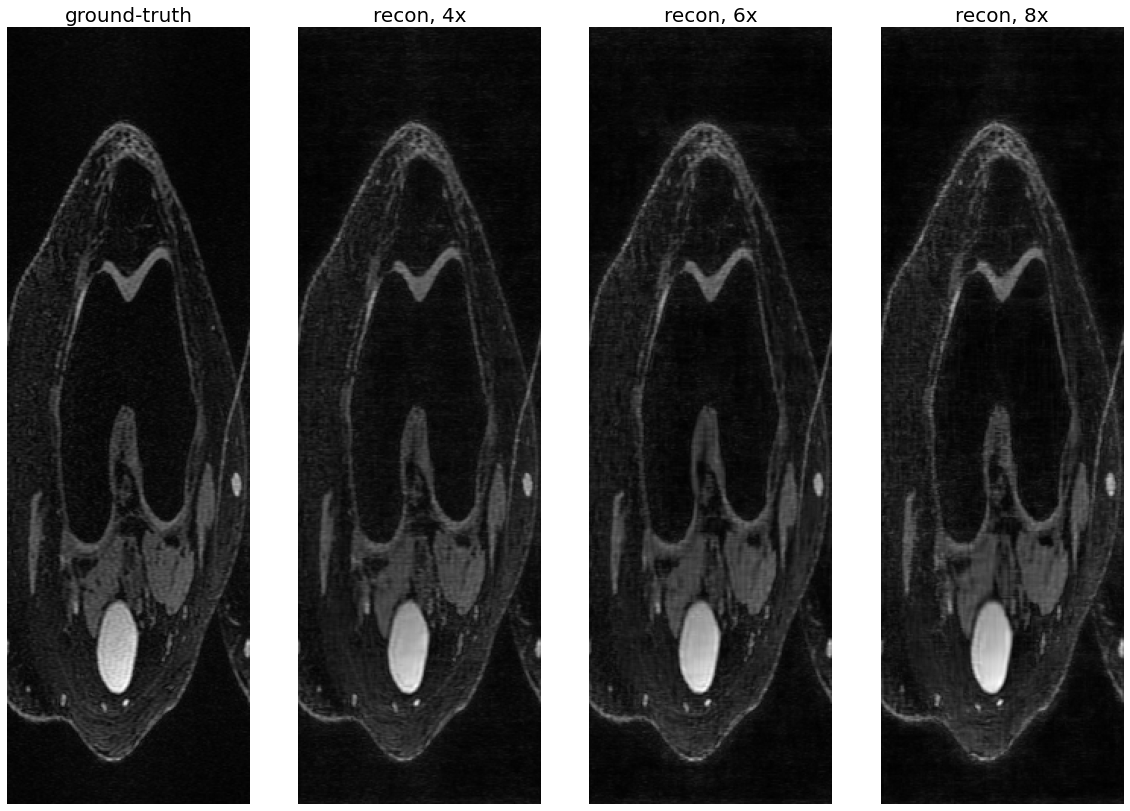

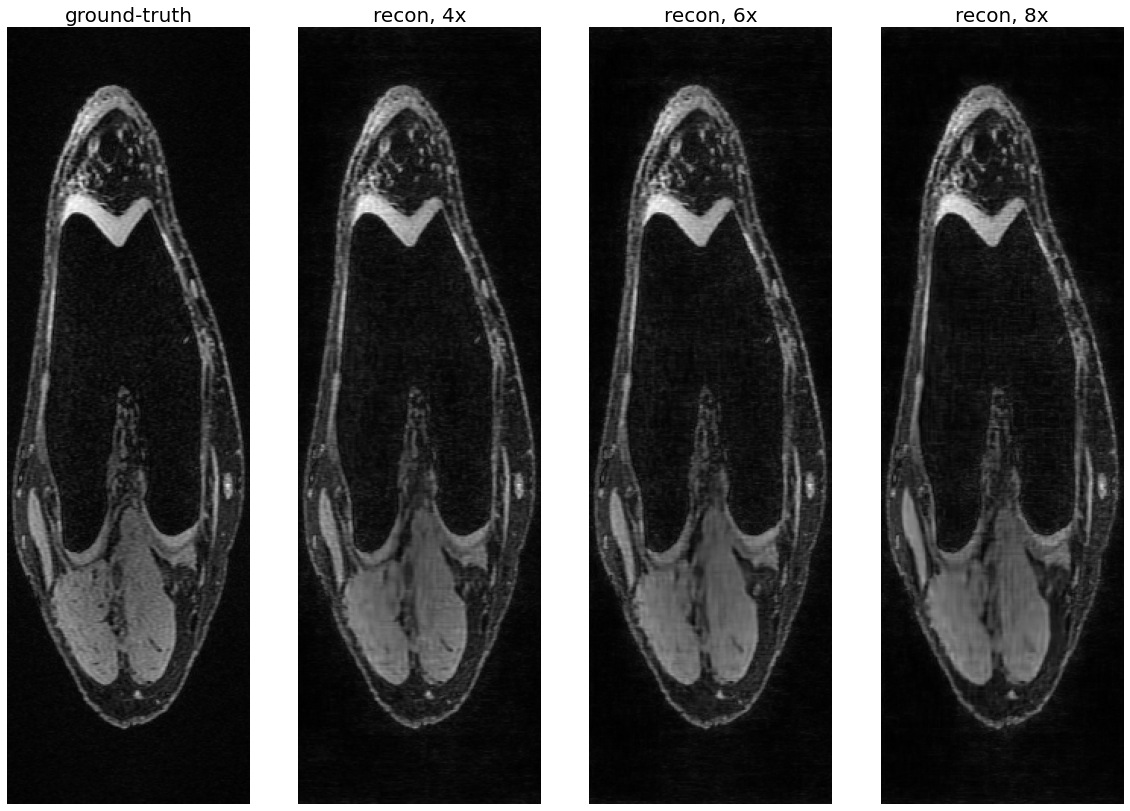

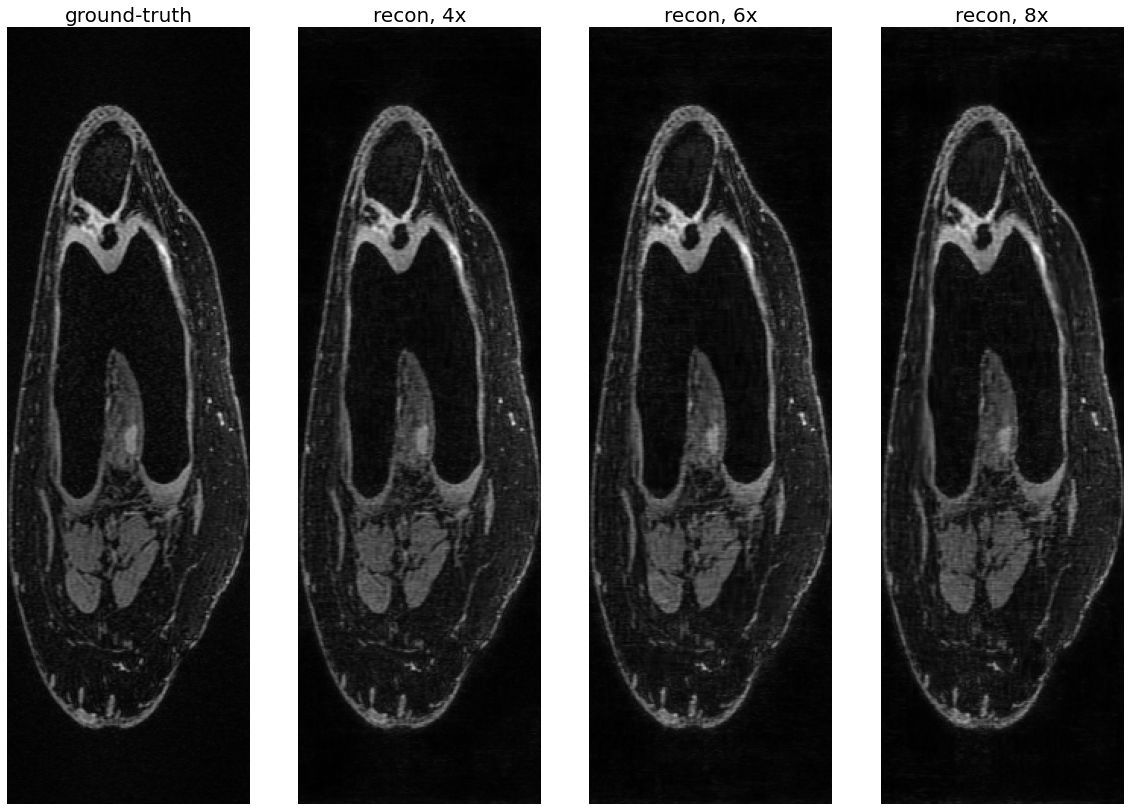

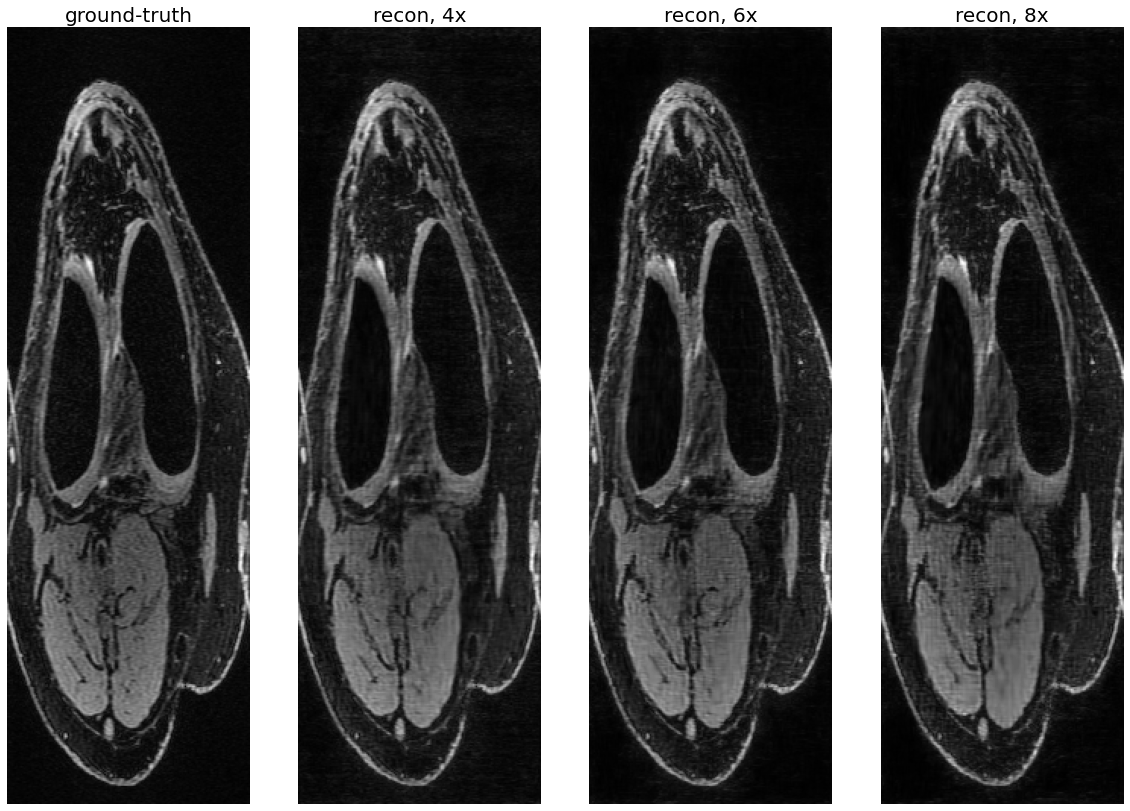

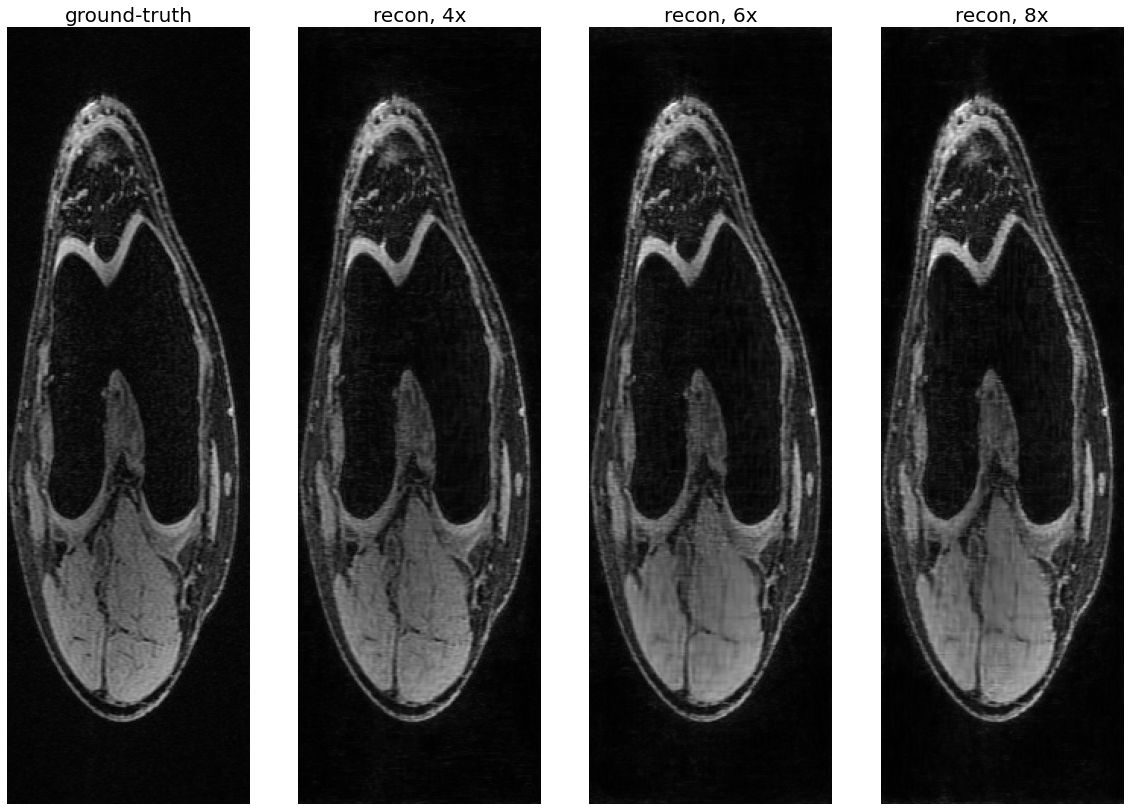

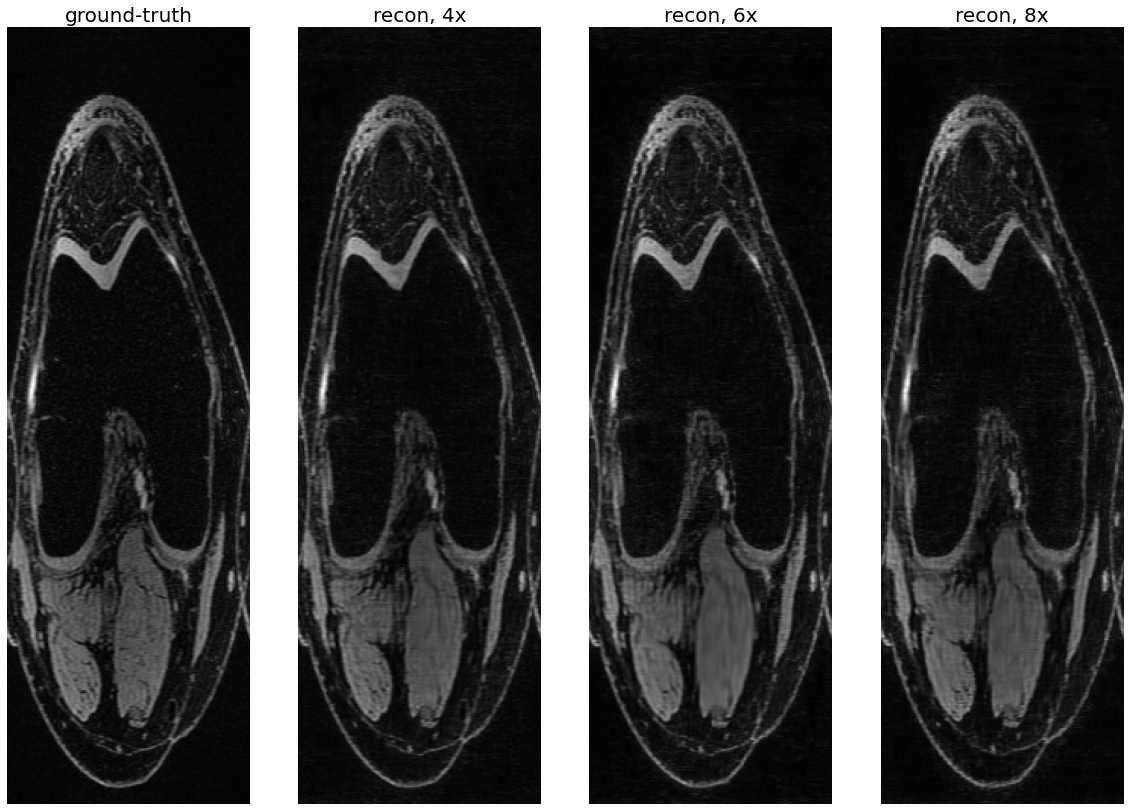

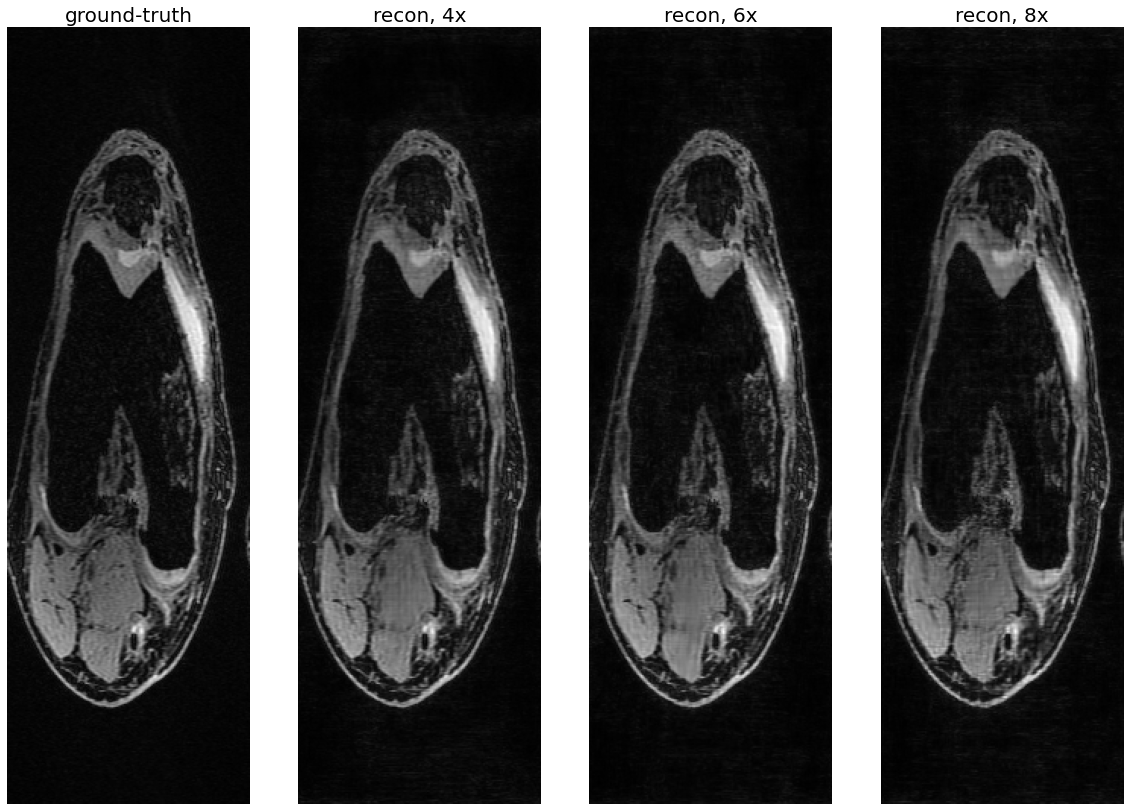

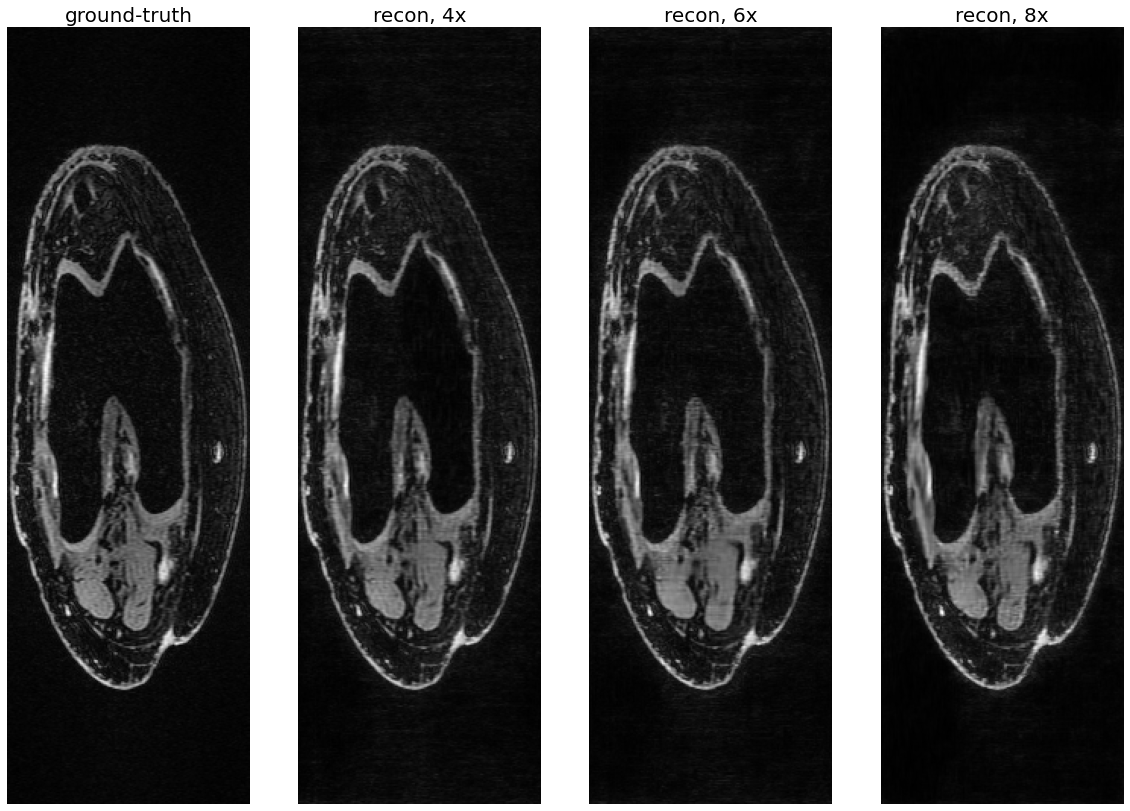

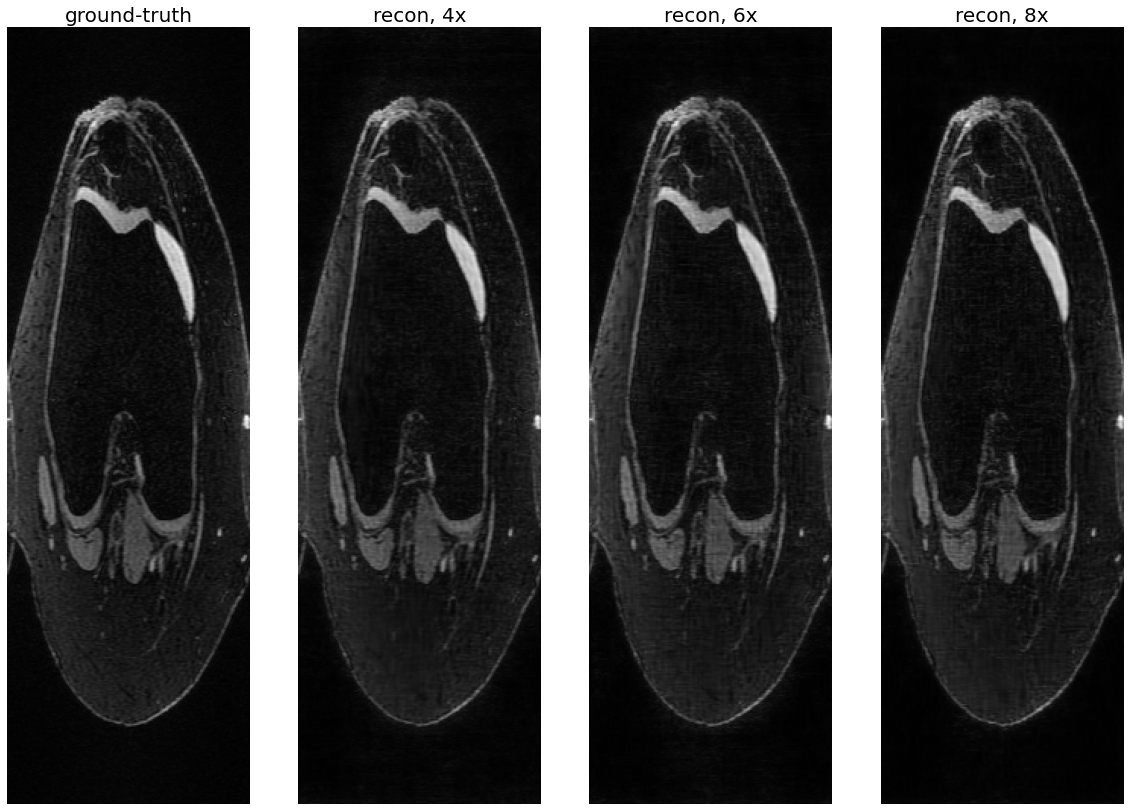

In [82]:
for idx in np.arange(NUM_SAMPS):
    plot_list(im_list[idx])
#     plot_list(im_diff_list[idx])